# System identification with Neural Networks
## Mohammad Qori Aziz Hakiki - 23222020

Based on Tarek A. Tutunji (2016) - Parametric system identification using neural networks

### 1. Import library

In [1]:
import os
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from collections import OrderedDict


### 2. Import Dataset From TXT

In [2]:
dataset = np.genfromtxt('6.txt',delimiter=';')
print(dataset)

# Get first column as input, skipping the header
input_tensor=torch.as_tensor(dataset[1:, 0], dtype=torch.float32)
input_tensor = torch.reshape(input_tensor, (len(input_tensor), 1))
# Get second column as output, skipping the header
output_tensor=torch.as_tensor(dataset[1:, 1], dtype=torch.float32)
output_tensor = torch.reshape(output_tensor, (len(output_tensor), 1))
input_tensor = input_tensor / 10
output_tensor = output_tensor / 200
print(input_tensor)
print(output_tensor)

[[      nan       nan       nan       nan]
 [ 5.        0.        0.        5.      ]
 [ 5.        1.06069  16.713107  5.      ]
 ...
 [ 0.        1.161356  0.        0.      ]
 [ 0.        1.010358  0.        0.      ]
 [ 0.        1.010358  0.        0.      ]]
tensor([[0.5000],
        [0.5000],
        [0.5000],
        ...,
        [0.0000],
        [0.0000],
        [0.0000]])
tensor([[0.0000],
        [0.0053],
        [0.0556],
        ...,
        [0.0058],
        [0.0051],
        [0.0051]])


### 3. Define and Apply Time Delay Block to datasets

Here we apply time delay to our data. Suppose we predict that our DC motor transfer function will be like this:

$$H(z) = \frac{Y(z)}{U(z)} = \frac{b_{0} + b_{1}z^{-1}}{1 - a_{1}z^{-1} - a_{2}z^{-2}}$$

In time-domain, 

$$y(k) =a_{1}y(k-1) + a_{2}y(k-2) + b_{0}u(k) + b_{1}u(k-1)$$

Based on the reference paper, we will estimate the $a_{i}$ and $b_{j}$ parameter from the weight of the NN.  

To do so, the neural network inputs will be the delayed target output and inputs, in our case $y(k-1), y(k-2), u(k),$ and $u(k-1)$.


In [3]:
def timedelayblock(input, target, inp_order, target_order):
    delayed_nn_input = input

    # Append delayed input
    for i in range(1, inp_order+1):
        concated_tensor =torch.roll(input, i, 0)
        for j in range(i):
            concated_tensor[j, 0] = 0 # force zeroing delayed input
        delayed_nn_input= torch.cat((delayed_nn_input, concated_tensor), 1)
    
    # Append delayed input
    for k in range(1, target_order+1):
        concated_tensor = torch.roll(target, k, 0)
        for l in range(k):
            concated_tensor[l, 0] = 0 # force zeroing delayed input
        delayed_nn_input= torch.cat((delayed_nn_input, concated_tensor), 1)
    return delayed_nn_input
inp_order = 1
out_order = 2
# Create x(k), x(k-1), y(k-1), and y(k-2)
nn_input= timedelayblock(input_tensor, output_tensor, inp_order, out_order)
print(nn_input[0:5, :])
print(nn_input.size())

tensor([[0.5000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0053, 0.0000],
        [0.5000, 0.5000, 0.0556, 0.0053],
        [0.5000, 0.5000, 0.1188, 0.0556]])
torch.Size([12473, 4])


In [4]:
# Split training and test data
nn_input_train = nn_input[:10000, :]
nn_input_test = nn_input[10000:, :]

y_train =output_tensor[:10000, :]
y_test = output_tensor[10000:, :]

### 4. Define NN Class

Define the NN model that will be used.  
Here we will add hidden layer and act function based on the parameters provided.

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_features, hidden_dim, hidden_layer, out_classes):
        super(NeuralNetwork, self).__init__()
        # Create ordered Dictionary based on the number of hidden_layer
        sequence = OrderedDict()
        for layer in range(hidden_layer):
            if layer == 0:
                sequence['hidden_layer_{}'.format(layer)] =nn.Linear(
                    in_features, hidden_dim, bias=False)
                sequence['activation_{}'.format(layer)] =  nn.Tanh()
                continue
            # For layer not in the input layer
            sequence['hidden_layer_{}'.format(layer)] = nn.Linear(
                hidden_dim, hidden_dim, bias=False)
            sequence['activation_{}'.format(layer)] = nn.Tanh()
        # Insert output layer
        sequence['output_layer'] = nn.Linear(hidden_dim, out_classes, bias=False)

        # print(sequence)
        # return the sequential model
        self.layer_stack = nn.Sequential(sequence)
        

    def forward(self, x):
        x = self.layer_stack(x)
        return x


In [6]:
# Variable declaration
# Since we have u(k), u(k-1), y(k-1), and y(k-2), we have 4 inputs.

in_features=inp_order + out_order +1  # how many Variables are in the dataset
hidden_dim= inp_order + out_order +1 # hidden i/o
hidden_layer=3 # how many hidden layers
output_dim=1   # number of classes
epoch = 100

In [7]:
clf=NeuralNetwork(in_features,hidden_dim, hidden_layer, output_dim)
print(clf)

params = clf.parameters()
# print(len(params))

for p in params:
    print(p.size())  # conv1's .weight
    print(p)

NeuralNetwork(
  (layer_stack): Sequential(
    (hidden_layer_0): Linear(in_features=4, out_features=4, bias=False)
    (activation_0): Tanh()
    (hidden_layer_1): Linear(in_features=4, out_features=4, bias=False)
    (activation_1): Tanh()
    (hidden_layer_2): Linear(in_features=4, out_features=4, bias=False)
    (activation_2): Tanh()
    (output_layer): Linear(in_features=4, out_features=1, bias=False)
  )
)
torch.Size([4, 4])
Parameter containing:
tensor([[-0.2195, -0.4338,  0.2974, -0.2574],
        [-0.2211, -0.3408, -0.0308, -0.3036],
        [-0.4234,  0.1784,  0.0461, -0.2000],
        [ 0.4588,  0.3540,  0.3386,  0.2488]], requires_grad=True)
torch.Size([4, 4])
Parameter containing:
tensor([[ 0.2843,  0.2700, -0.2902,  0.4077],
        [ 0.0309, -0.3195,  0.0726, -0.2782],
        [-0.3190, -0.2324,  0.4664,  0.3790],
        [-0.0139, -0.3290,  0.0647, -0.1850]], requires_grad=True)
torch.Size([4, 4])
Parameter containing:
tensor([[ 0.4985, -0.4261, -0.0616,  0.4351],
    

### 5. Compute weight and biases of our networks

In [8]:
# Test our networks
out = clf(nn_input_train)
print(out)

tensor([[0.0130],
        [0.0655],
        [0.0655],
        ...,
        [0.0501],
        [0.0502],
        [0.0502]], grad_fn=<MmBackward0>)


In [9]:
# Construct loss function for learning
criterion = nn.MSELoss()
# Construct the optimizer (Stochastic Gradient Descent in this case)
optimizer = torch.optim.SGD(clf.parameters(), lr = 0.3)

In [10]:
for e in range(epoch):
   # Forward pass: Compute predicted y by passing x to the model
   y_pred = clf(nn_input_train)

   # Compute and print loss
   loss = criterion(y_pred, y_train)
   print('epoch: ', e,' loss: ', loss.item())

   # Zero gradients, perform a backward pass, and update the weights.
   optimizer.zero_grad()

   # perform a backward pass (backpropagation)
   loss.backward()

   # Update the parameters
   optimizer.step()

epoch:  0  loss:  0.27765217423439026
epoch:  1  loss:  0.23957954347133636
epoch:  2  loss:  0.19250613451004028
epoch:  3  loss:  0.13973428308963776
epoch:  4  loss:  0.08984465152025223
epoch:  5  loss:  0.05286288633942604
epoch:  6  loss:  0.03248463198542595
epoch:  7  loss:  0.0241682305932045
epoch:  8  loss:  0.021442648023366928
epoch:  9  loss:  0.02054711990058422
epoch:  10  loss:  0.020125625655055046
epoch:  11  loss:  0.019813548773527145
epoch:  12  loss:  0.019528241828083992
epoch:  13  loss:  0.019252663478255272
epoch:  14  loss:  0.01898345723748207
epoch:  15  loss:  0.01871991530060768
epoch:  16  loss:  0.01846183091402054
epoch:  17  loss:  0.018209073692560196
epoch:  18  loss:  0.017961515113711357
epoch:  19  loss:  0.01771903596818447
epoch:  20  loss:  0.01748151332139969
epoch:  21  loss:  0.01724882796406746
epoch:  22  loss:  0.01702086441218853
epoch:  23  loss:  0.016797499731183052
epoch:  24  loss:  0.016578616574406624
epoch:  25  loss:  0.016364

In [11]:
for param in clf.parameters():
   print(param)

# Loss testing
y_pred_test = clf(nn_input_test)
print(y_pred_test)
loss = criterion(y_pred_test, y_test)
print(' loss: ', loss.item())

Parameter containing:
tensor([[-0.1816, -0.3970,  0.2218, -0.3334],
        [-0.1384, -0.2593, -0.0457, -0.3188],
        [-0.4169,  0.1861,  0.1907, -0.0549],
        [ 0.2951,  0.1918,  0.2827,  0.1933]], requires_grad=True)
Parameter containing:
tensor([[ 0.2458,  0.2147, -0.2942,  0.4700],
        [ 0.1066, -0.2126,  0.0815, -0.4010],
        [-0.3476, -0.3380,  0.4526,  0.4568],
        [-0.0915, -0.4473,  0.0522, -0.0529]], requires_grad=True)
Parameter containing:
tensor([[ 0.5313, -0.4704,  0.1748,  0.5134],
        [-0.2510, -0.3312,  0.6401, -0.0119],
        [-0.0512, -0.4102, -0.8125, -0.2464],
        [-0.0380, -0.3080,  0.3802, -0.3161]], requires_grad=True)
Parameter containing:
tensor([[ 0.4938,  0.6940, -0.8279,  0.2569]], requires_grad=True)
tensor([[0.3593],
        [0.3610],
        [0.3582],
        ...,
        [0.0042],
        [0.0038],
        [0.0037]], grad_fn=<MmBackward0>)
 loss:  0.002541043097153306


tensor([[0.3593],
        [0.3610],
        [0.3582],
        ...,
        [0.0042],
        [0.0038],
        [0.0037]], grad_fn=<MmBackward0>)


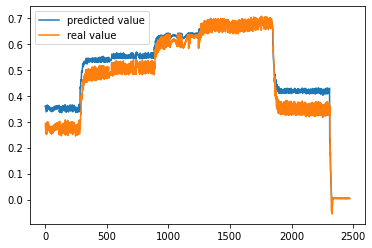

In [12]:
import matplotlib.pyplot as plt
nn_input_test = nn_input_test.detach().numpy()

y_pred_test_detach = y_pred_test.detach().numpy()

y_test = y_test.detach().numpy()
# plt.plot(nn_input_test, label='input value')
plt.plot(y_pred_test_detach, label='predicted value')
plt.plot(y_test, label='real value')
leg = plt.legend()

print(y_pred_test)

In [13]:
# Check weight
params = clf.named_parameters()

for p in params:
    print(p)

('layer_stack.hidden_layer_0.weight', Parameter containing:
tensor([[-0.1816, -0.3970,  0.2218, -0.3334],
        [-0.1384, -0.2593, -0.0457, -0.3188],
        [-0.4169,  0.1861,  0.1907, -0.0549],
        [ 0.2951,  0.1918,  0.2827,  0.1933]], requires_grad=True))
('layer_stack.hidden_layer_1.weight', Parameter containing:
tensor([[ 0.2458,  0.2147, -0.2942,  0.4700],
        [ 0.1066, -0.2126,  0.0815, -0.4010],
        [-0.3476, -0.3380,  0.4526,  0.4568],
        [-0.0915, -0.4473,  0.0522, -0.0529]], requires_grad=True))
('layer_stack.hidden_layer_2.weight', Parameter containing:
tensor([[ 0.5313, -0.4704,  0.1748,  0.5134],
        [-0.2510, -0.3312,  0.6401, -0.0119],
        [-0.0512, -0.4102, -0.8125, -0.2464],
        [-0.0380, -0.3080,  0.3802, -0.3161]], requires_grad=True))
('layer_stack.output_layer.weight', Parameter containing:
tensor([[ 0.4938,  0.6940, -0.8279,  0.2569]], requires_grad=True))


### 6. Transform NN Weights to Transfer Function

In here, we define an NN2TF algorithm. Based on the reference paper, the parameter $a_{j}$ and $b_{i}$ can be estimated by

$$a_{j} = (\sum_{h=1}^H (wout_{h}v_{jh}))$$

$$b_{i} = (\sum_{h=1}^H (wout_{h}w_{ih}))$$

For tanh activation function.

In [14]:
def nn2tf(nn, hidden_layer, inp_order, target_order):
    regressor = np.zeros((1, inp_order+target_order+1))
    wout = nn.state_dict()['layer_stack.output_layer.weight']
    wout = wout.numpy()
    print('wout : ', wout)
    # print(wout.size())
    params = nn.named_parameters()
    i = 0
    for p in params:
        # print(p)

        w_hidden = nn.state_dict()['layer_stack.hidden_layer_{}.weight'.format(i)]
        w_hidden = w_hidden.numpy()
        print('w_hidden : ', w_hidden)
        # Update regressor
        regressor = regressor + (wout @ w_hidden)
        print(regressor)

        i = i + 1
        if i == hidden_layer :
            break
    
    # regressor = regressor * 0.5
    return regressor


regressor = nn2tf(clf, hidden_layer, inp_order, out_order)
print(regressor)

wout :  [[ 0.4937596   0.69395536 -0.82785094  0.2569408 ]]
w_hidden :  [[-0.18156643 -0.39702338  0.22181033 -0.33336785]
 [-0.13844931 -0.2593085  -0.04569519 -0.31883627]
 [-0.41686112  0.18612272  0.19070208 -0.05490927]
 [ 0.2951307   0.19176437  0.28271168  0.19329816]]
[[ 0.23520218 -0.48079237 -0.00742217 -0.29073882]]
w_hidden :  [[ 0.24576595  0.21468757 -0.29420993  0.469956  ]
 [ 0.1065579  -0.21259223  0.08149514 -0.40096304]
 [-0.34757522 -0.33798665  0.4525755   0.45677227]
 [-0.09145127 -0.4473172   0.05216832 -0.05293814]]
[[ 0.69474082 -0.35744932 -0.45739808 -0.72868529]]
w_hidden :  [[ 0.53130066 -0.47041947  0.17481987  0.51342124]
 [-0.25099543 -0.33121866  0.6400511  -0.01188512]
 [-0.05116581 -0.41019574 -0.8124677  -0.24638972]
 [-0.03795148 -0.30796766  0.38016725 -0.31614786]]
[[ 0.81550235 -0.55912296  0.84337053 -0.36068371]]
[[ 0.81550235 -0.55912296  0.84337053 -0.36068371]]


In [15]:
# Stabilize pole, use if there are unstable pole

# for i in range(inp_order + 1, len(regressor[0])):
#     print(i)
#     while abs(regressor[0][i]) > 1:
#         regressor[0][i]= regressor[0][i] * 0.9
#         # print(regressor[0][i])
#         print(regressor)


In [16]:
# # Calculate estimated output from our model
y_pred = np.zeros((len(output_tensor),1))

nn_input_detach = nn_input.detach().numpy()

# for i in range(len(output_tensor)):
#     for j in range (len(regressor)):
#         y_pred[i] += regressor[0][j] * nn_input_detach[i][j]
   

In [17]:
# # Plot estimated output

# print(y_pred)
# plt.plot(y_pred, label='estimated value')
# plt.plot(output_tensor, label='real value')
# leg = plt.legend()


In [18]:
 # Calculate estimated output from our model
for i in range(len(output_tensor)):
    if i == 0 :
        y_pred[i] = regressor[0][0] * nn_input_detach[i][0]
        continue
    
    # Fill y(k-1)
    if i >= 1 :
        nn_input_detach[i][2] = y_pred[i-1]
    
        # Fill y(k-2)
    if i >=2 :
        nn_input_detach[i][3] = y_pred[i-2]

    for j in range (len(regressor)):
        y_pred[i] += regressor[0][j] * nn_input_detach[i][j]

[[0.40775117]
 [0.40775117]
 [0.40775117]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]


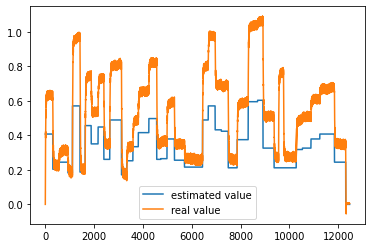

In [19]:
# Plot estimated output

print(y_pred)
plt.plot(y_pred, label='estimated value')
plt.plot(output_tensor, label='real value')
leg = plt.legend()